# Analyse modelled fluxes

- Should also compare results of gridded NEE predictions (correlations etc.) with EC point data to see if they follow the same trends. 

In [1]:
import sys
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.diskutils - INFO - Found stale lock file and directory '/local/u46/cb3058/tmp/dask-worker-space/worker-u8lzipst', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39241,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:36203,Total threads: 16
Dashboard: /proxy/33859/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:34041,


In [3]:
var = 'GPP'
results_name = 'GPP_2003_2021.nc'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2002-10_2021.nc'

## Open predictor data

In [4]:
data = xr.open_dataset(data_path)

## Open predictions

In [24]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name,
                       chunks=dict(x=250,y=250, time=-1)).sel(time=slice('2003','2018'))

## Linear trends

In [26]:
# import xarray as xr
import dask.array as da
from dask.delayed import delayed
from  scipy import stats

def _calc_slope(y):
    """return linear regression statistical variables"""
    mask = np.isfinite(y)
    x = np.arange(len(y))
    return stats.linregress(x[mask], y[mask])

# regression function defition
def regression(y):
    """apply linear regression function along time axis"""
    axis_num = y.get_axis_num('time')
    return da.apply_along_axis(_calc_slope, axis_num, y)

# fill pixels that are all-NaNs
allnans = ds.isnull().all('time').compute()
ds = ds.where(~allnans, other=0)

# regression analysis
delayed_objs = delayed(regression)(ds).persist()

# transforms dask.delayed to dask.array
results = da.from_delayed(delayed_objs, shape=(5, ds.shape[1:][0], ds.shape[1:][1]), dtype=np.float32)
results = results.compute()
results = results.compute() #need this twice haven't figured out why

# statistical variables definition
variables = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

# coordination definition
coords = {'y': ds.y, 'x': ds.x}

# output xarray.Dataset definition
ds_out = xr.Dataset(
    data_vars=dict(slope=(["y", "x"], results[0]),
                   intercept=(["y", "x"], results[1]),
                   r_value=(["y", "x"], results[2]),
                   p_value=(["y", "x"], results[3]),
                   std_err=(["y", "x"], results[4]),
                  ),
    coords = coords)

#remask all-NaN pixel
ds_out = ds_out.where(~allnans)
ds_out

/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy

### Mask with Evergreen Trees

In [32]:
lc = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/IGBP_Landcover_MODIS_5km.nc').isel(time=1)
lc['latitude'] = lc.latitude.astype('float32')
lc['longitude'] = lc.longitude.astype('float32')
lc = lc.rename({'latitude':'y','longitude':'x'})

trees = lc.IGBP_class == 2

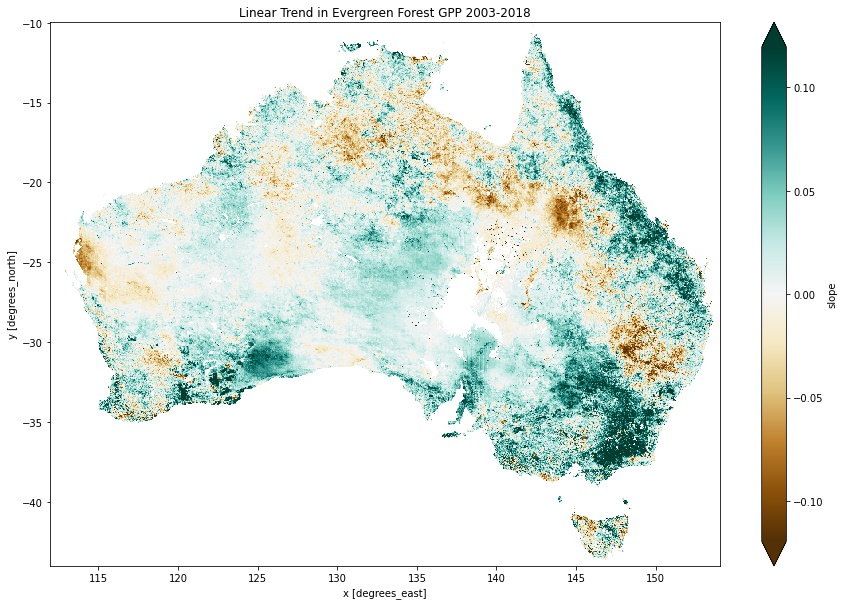

In [42]:
ds_out.slope.plot.imshow(size=10, robust=True, cmap='BrBG')
plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

# Correlations

TODO: compute p-values and plot hashes over areas with significance > 0.05
https://xskillscore.readthedocs.io/en/stable/api/xskillscore.pearson_r_eff_p_value.html

In [ ]:
data = data.sel(time=nee.time) #match times

In [ ]:
precip_corr = xr.corr(nee, data['rain'], dim='time').compute()
lai_corr = xr.corr(nee, data['lai'], dim='time').compute()
sm_corr = xr.corr(nee, data['soil_moisture'], dim='time').compute()
tavg_corr = xr.corr(nee, data['tavg'], dim='time').compute()

In [ ]:
sm_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & Soil Moisture');

In [ ]:
lai_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & Leaf Area Index');

In [ ]:
tavg_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & Average Temperature');

In [ ]:
precip_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & Precipitation');

## Plot relationships between NEE, GPP, ER and environmental variables (P, T, SM etc)

Following Lui et al. (2018) 

## Causality

###  Granger casaulity tests?

### Bayesian structure learning?
https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(ndvi, variables = ndvi.columns)  